# Exploratory Data Analysis

In [16]:
# load library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import zipfile
import urllib.request
import io

In [11]:
# load raw data
DATA_DIR = "https://raw.githubusercontent.com/sitayang-code/STAT3612_Group_Project/refs/heads/main/STAT3612_Group_Project/ehr_preprocessed_seq_by_day_cat_embedding.pkl.zip"
with urllib.request.urlopen(DATA_DIR) as response:
    with zipfile.ZipFile(io.BytesIO(response.read())) as zip_file:
        with zip_file.open("ehr_preprocessed_seq_by_day_cat_embedding.pkl", "r") as file:
            EHR = pd.read_pickle(file)
train = pd.read_csv("https://raw.githubusercontent.com/sitayang-code/STAT3612_Group_Project/refs/heads/main/STAT3612_Group_Project/train.csv")
valid = pd.read_csv("https://raw.githubusercontent.com/sitayang-code/STAT3612_Group_Project/refs/heads/main/STAT3612_Group_Project/valid.csv")
test = pd.read_csv("https://raw.githubusercontent.com/sitayang-code/STAT3612_Group_Project/refs/heads/main/STAT3612_Group_Project/test.csv")
print(train.shape)
print(test.shape)
print(valid.shape)
print(len(EHR['feature_cols']))

(49451, 8)
(16293, 7)
(16721, 8)
171


In [14]:
# extract last-day observations
train_masked = train.drop_duplicates(subset = 'id', keep = 'last')
valid_masked = valid.drop_duplicates(subset = 'id', keep = 'last')
test_masked = test.drop_duplicates(subset = 'id', keep = 'last')

print(train_masked.shape)
print(valid_masked.shape)
print(test_masked.shape)

(8234, 8)
(2788, 8)
(2741, 7)


In [18]:
# merge train and valid
train = pd.concat([train, valid])
train_masked = pd.concat([train_masked, valid_masked])
print(train.shape)
print(train_masked.shape)

(66172, 8)
(11022, 8)


In [22]:
# construct merged dataframe (admit info + feature value)
def merge_admits(masked_df, feat_dict, feature_cols):
    merged_admits_latest = []
    merged_admits_median = []
    
    for _, admit in masked_df.iterrows():
        feat_arr_latest = pd.Series(feat_dict[admit['id']][-1], index=feature_cols)
        feat_arr_median = round(pd.Series(np.nanmedian(feat_dict[admit['id']], axis=0), index=feature_cols))
        
        merged_admits_latest.append(pd.concat([admit, feat_arr_latest]))
        merged_admits_median.append(pd.concat([admit, feat_arr_median]))
        
    return pd.DataFrame(merged_admits_latest), pd.DataFrame(merged_admits_median)

# Merge train and test data
train_merged_df_latest, train_merged_df_median = merge_admits(train_masked, EHR['feat_dict'], EHR['feature_cols'])
test_merged_df_latest, test_merged_df_median = merge_admits(test_masked, EHR['feat_dict'], EHR['feature_cols'])

# Output the shape and preview of the latest train merged dataframe
print(train_merged_df_latest.shape)
train_merged_df_latest.head(5)

(11022, 179)


id  subject_id   hadm_id  \
0  10869829_25238191    10869829  25238191   
1  12347278_29852086    12347278  29852086   
2  11157850_29572307    11157850  29572307   
3  11958726_24320913    11958726  24320913   
4  11944377_26689168    11944377  26689168   

                                       dicom_id  study_id ViewPosition  \
0  cc0d53de-4a394a45-dde65f7c-b022a912-5c0d3e5c  56056422           AP   
1  49ca72c6-81364fa8-8f2fe12f-ceeba2ea-fb73ba73  55687417           AP   
2  ea1e314a-97b3c673-d13c9474-02287cd8-40a3f1aa  58509117           AP   
3  1180dc40-14a7d3f6-8e7bfbfe-cbf83473-3217174a  59423150           AP   
4  31a102b6-e48bb88c-6f7fa543-a359e525-58a8d187  59985023           AP   

                                         image_path  readmitted_within_30days  \
0  cc0d53de-4a394a45-dde65f7c-b022a912-5c0d3e5c.jpg                     False   
1  49ca72c6-81364fa8-8f2fe12f-ceeba2ea-fb73ba73.jpg                     False   
2  ea1e314a-97b3c673-d13c9474-02287cd8-40a3f1aa.jpg                      True   
3  1180dc40-14a7d3f6-8e7bfbfe-cbf83473-3217174a.jpg                     False   
4  31a102b6-e48bb88c-6f7fa543-a359e525-58a8d187.jpg                     False   

   age  gender  ...  PRE-NATAL VITAMINS  ANESTHETICS  ANTIBIOTICS  \
0   52       1  ...                   0            0           18   
1   62       1  ...                   0            1            3   
2   51       1  ...                   0            0            1   
3   75       0  ...                   0            1           19   
4   45       1  ...                   0            0            2   

   ANTIHYPERGLYCEMICS  ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS  \
0                   4                                                  0    
1                   0                                                  0    
2                   1                                                  0    
3                   3                                                  0    
4                   1                                                  0    

   SEDATIVE/HYPNOTICS  ANTIDOTES  AUTONOMIC DRUGS  VITAMINS  BIOLOGICALS  
0                   3          0                0         0            0  
1                   0          0                0         1            0  
2                   9          0                2         0            0  
3                   1          1                1         3            0  
4                   1          0                0         0            0  

[5 rows x 179 columns]

In [24]:
# summary statistics
train_merged_df_latest.describe()
#train_merged_df_median.describe()

subject_id       hadm_id      study_id           age        gender  \
count  1.102200e+04  1.102200e+04  1.102200e+04  11022.000000  11022.000000   
mean   1.496199e+07  2.499211e+07  5.773067e+07     66.113591      0.549719   
std    2.875893e+06  2.903536e+06  2.086291e+06     16.257087      0.497544   
min    1.000188e+07  2.000130e+07  5.003185e+07     18.000000      0.000000   
25%    1.247846e+07  2.247382e+07  5.658928e+07     57.000000      0.000000   
50%    1.496252e+07  2.503079e+07  5.840187e+07     68.000000      1.000000   
75%    1.744568e+07  2.750250e+07  5.938758e+07     78.000000      1.000000   
max    1.999999e+07  2.999910e+07  5.999983e+07     99.000000      1.000000   

          ethnicity       Y90-Y99       G30-G32  O85-O92       C60-C63  ...  \
count  11022.000000  11022.000000  11022.000000  11022.0  11022.000000  ...   
mean       5.061241      0.001542      0.000363      0.0      0.002631  ...   
std        1.604415      0.039244      0.019048      0.0      0.051229  ...   
min        0.000000      0.000000      0.000000      0.0      0.000000  ...   
25%        5.000000      0.000000      0.000000      0.0      0.000000  ...   
50%        6.000000      0.000000      0.000000      0.0      0.000000  ...   
75%        6.000000      0.000000      0.000000      0.0      0.000000  ...   
max        6.000000      1.000000      1.000000      0.0      1.000000  ...   

       PRE-NATAL VITAMINS   ANESTHETICS   ANTIBIOTICS  ANTIHYPERGLYCEMICS  \
count        11022.000000  11022.000000  11022.000000        11022.000000   
mean             0.000181      0.702595      4.793504            3.695337   
std              0.013470      1.493327      6.097966           10.497570   
min              0.000000      0.000000      0.000000            0.000000   
25%              0.000000      0.000000      1.000000            0.000000   
50%              0.000000      0.000000      3.000000            0.000000   
75%              0.000000      1.000000      7.000000            3.000000   
max              1.000000     29.000000     94.000000          243.000000   

       ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS  SEDATIVE/HYPNOTICS  \
count                                            11022.0         11022.000000   
mean                                                 0.0             1.184449   
std                                                  0.0             2.758067   
min                                                  0.0             0.000000   
25%                                                  0.0             0.000000   
50%                                                  0.0             0.000000   
75%                                                  0.0             1.000000   
max                                                  0.0            74.000000   

          ANTIDOTES  AUTONOMIC DRUGS      VITAMINS   BIOLOGICALS  
count  11022.000000     11022.000000  11022.000000  11022.000000  
mean       0.005534         0.375975      0.350118      0.173108  
std        0.106355         1.259100      0.921464      0.564320  
min        0.000000         0.000000      0.000000      0.000000  
25%        0.000000         0.000000      0.000000      0.000000  
50%        0.000000         0.000000      0.000000      0.000000  
75%        0.000000         0.000000      0.000000      0.000000  
max        4.000000        20.000000     16.000000     12.000000  

[8 rows x 174 columns]

In [26]:
# check missing values
feat_arrs = []
for id in train_masked['id']:
    feat_arrs.extend(EHR['feat_dict'][id])
feat_mat = np.vstack(feat_arrs)
num_nan = np.isnan(feat_mat).sum(axis=0)
print(num_nan)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [30]:
# extract categorical features
cat_cols = [EHR['feature_cols'][i] for i in EHR['cat_idxs']] 
icd_cols = EHR['icd_cols']
cat_cols.append('readmitted_within_30days')

Categorical features:


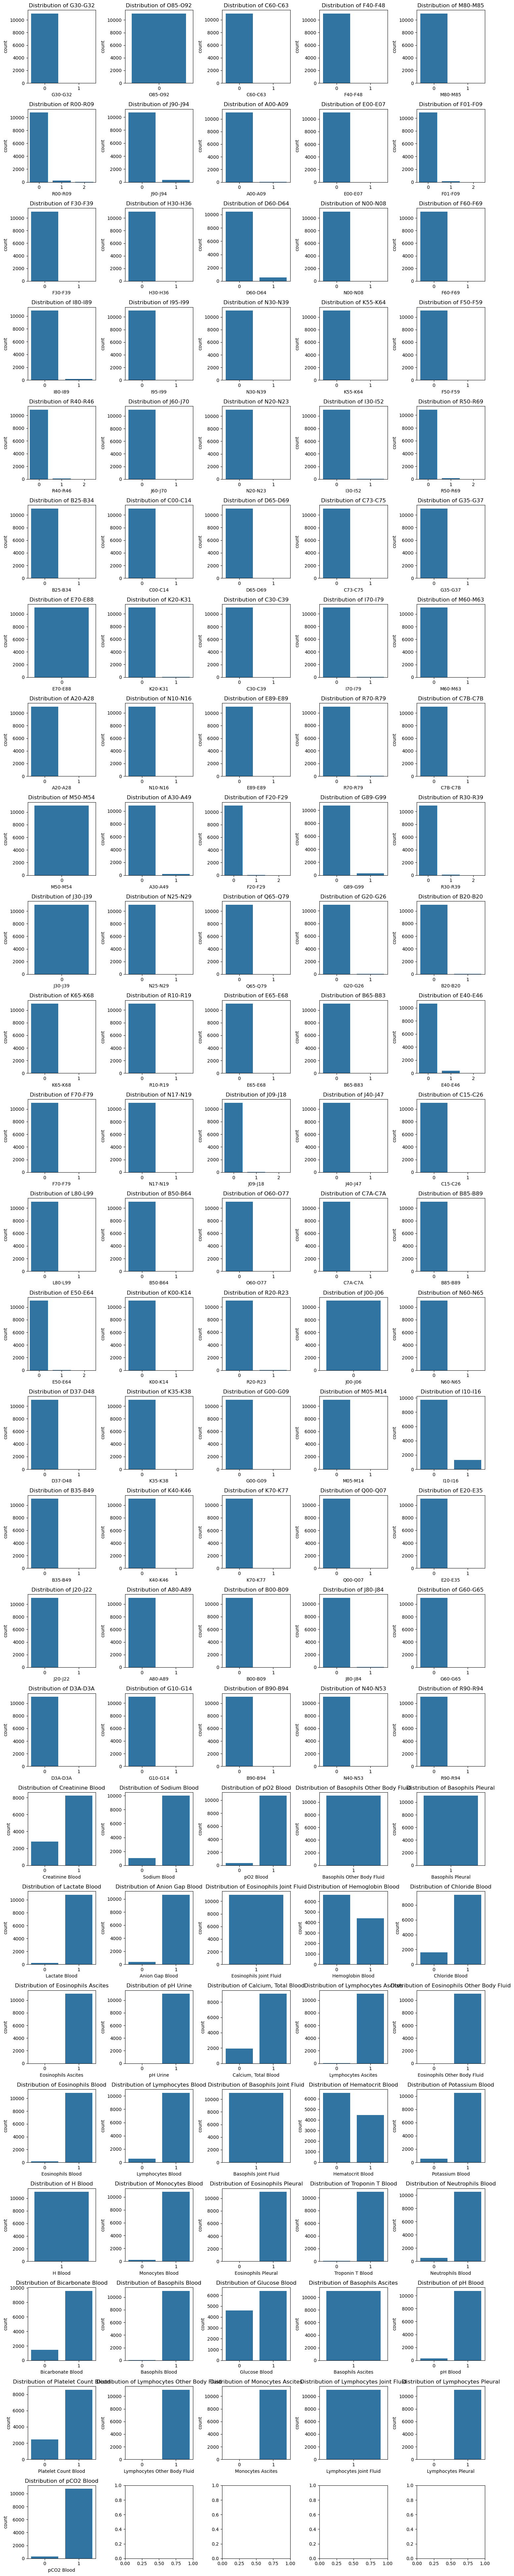

Numerical features:


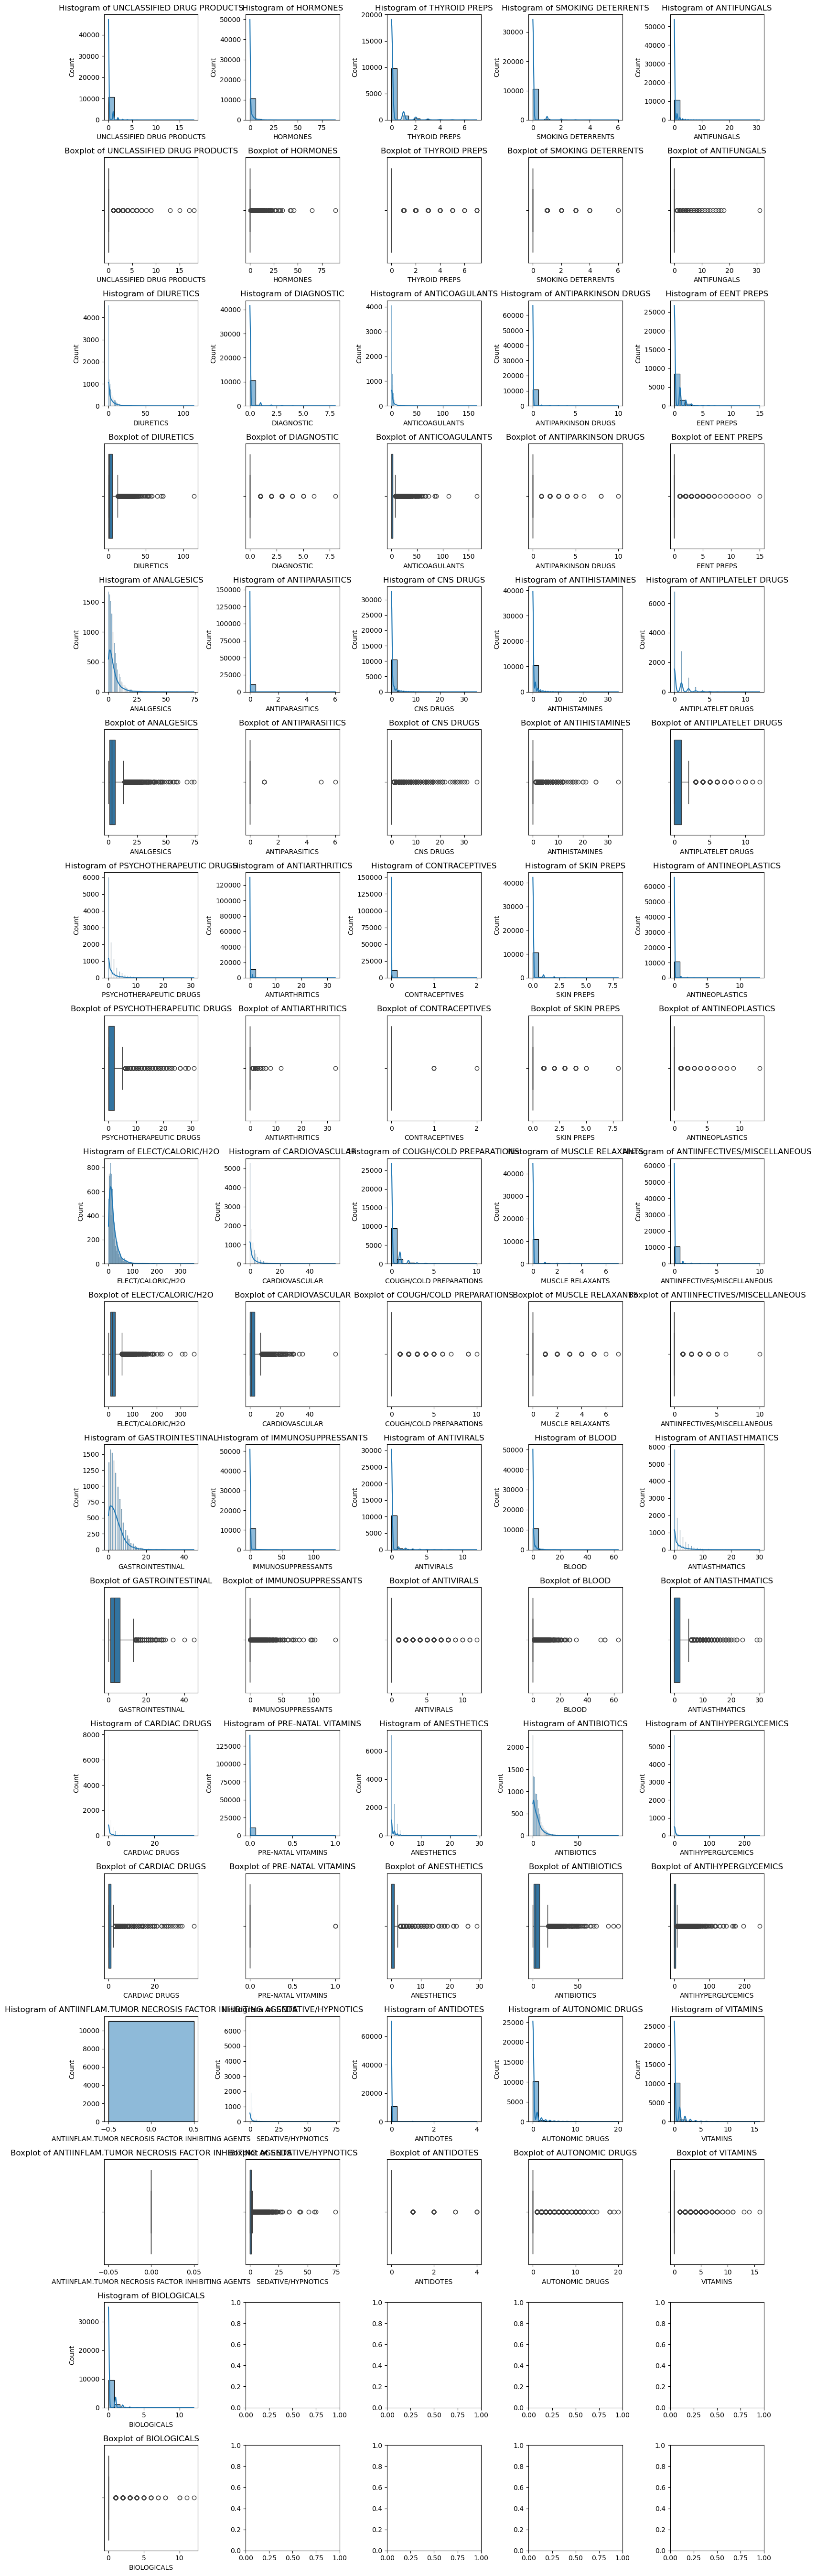

In [32]:
# Select categorical and numerical columns for the latest feature values
cat_cols_latest = [col for col in train_merged_df_latest.columns[12:] if col in cat_cols or col in icd_cols]
num_cols_latest = [col for col in train_merged_df_latest.columns[12:] if col not in cat_cols_latest]

# Plot categorical features
print("Categorical features:")
num_rows_cat = math.ceil(len(cat_cols_latest) / 5)
fig_cat, axs_cat = plt.subplots(num_rows_cat, 5, figsize=(15, num_rows_cat * 3))
axs_cat = axs_cat.flatten()

for i, col in enumerate(cat_cols_latest):
    sns.countplot(x=col, data=train_merged_df_latest, ax=axs_cat[i])
    axs_cat[i].set_title(f'Distribution of {col}')
    
plt.tight_layout()
plt.show()

# Plot numerical features
print("Numerical features:")
num_rows_num = math.ceil(len(num_cols_latest) / 5) * 2  
fig_num, axs_num = plt.subplots(num_rows_num, 5, figsize=(15, num_rows_num * 3))
axs_num = axs_num.flatten()

for i, col in enumerate(num_cols_latest):
    row = (i // 5) * 2  
    sns.histplot(train_merged_df_latest[col], kde=True, ax=axs_num[row * 5 + i % 5])  
    sns.boxplot(x=train_merged_df_latest[col], ax=axs_num[(row + 1) * 5 + i % 5])  
    axs_num[row * 5 + i % 5].set_title(f'Histogram of {col}')
    axs_num[(row + 1) * 5 + i % 5].set_title(f'Boxplot of {col}')
    
plt.tight_layout()
plt.show()

Categorical features:


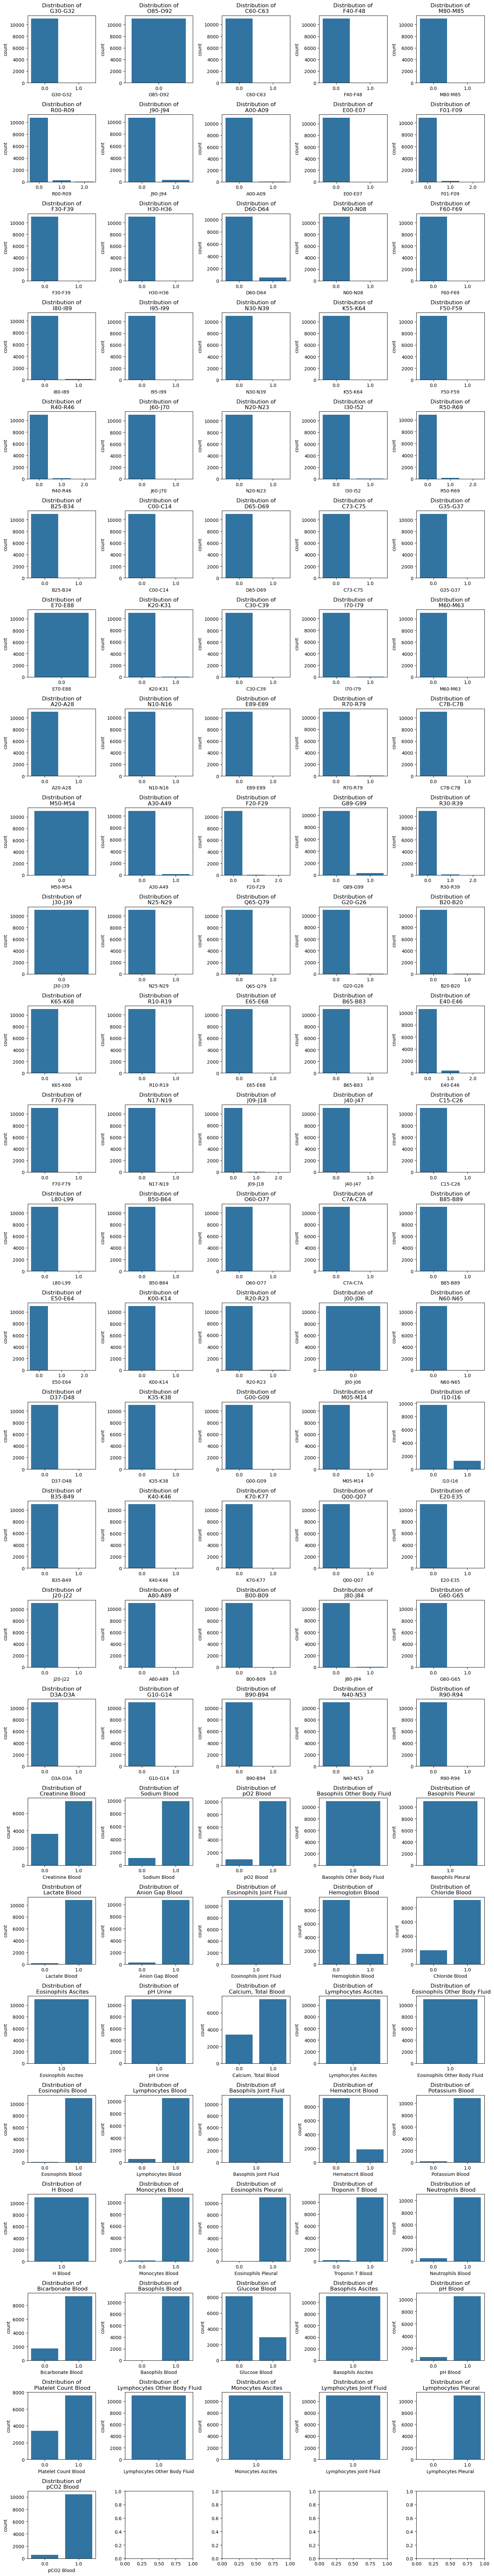

Numerical features:


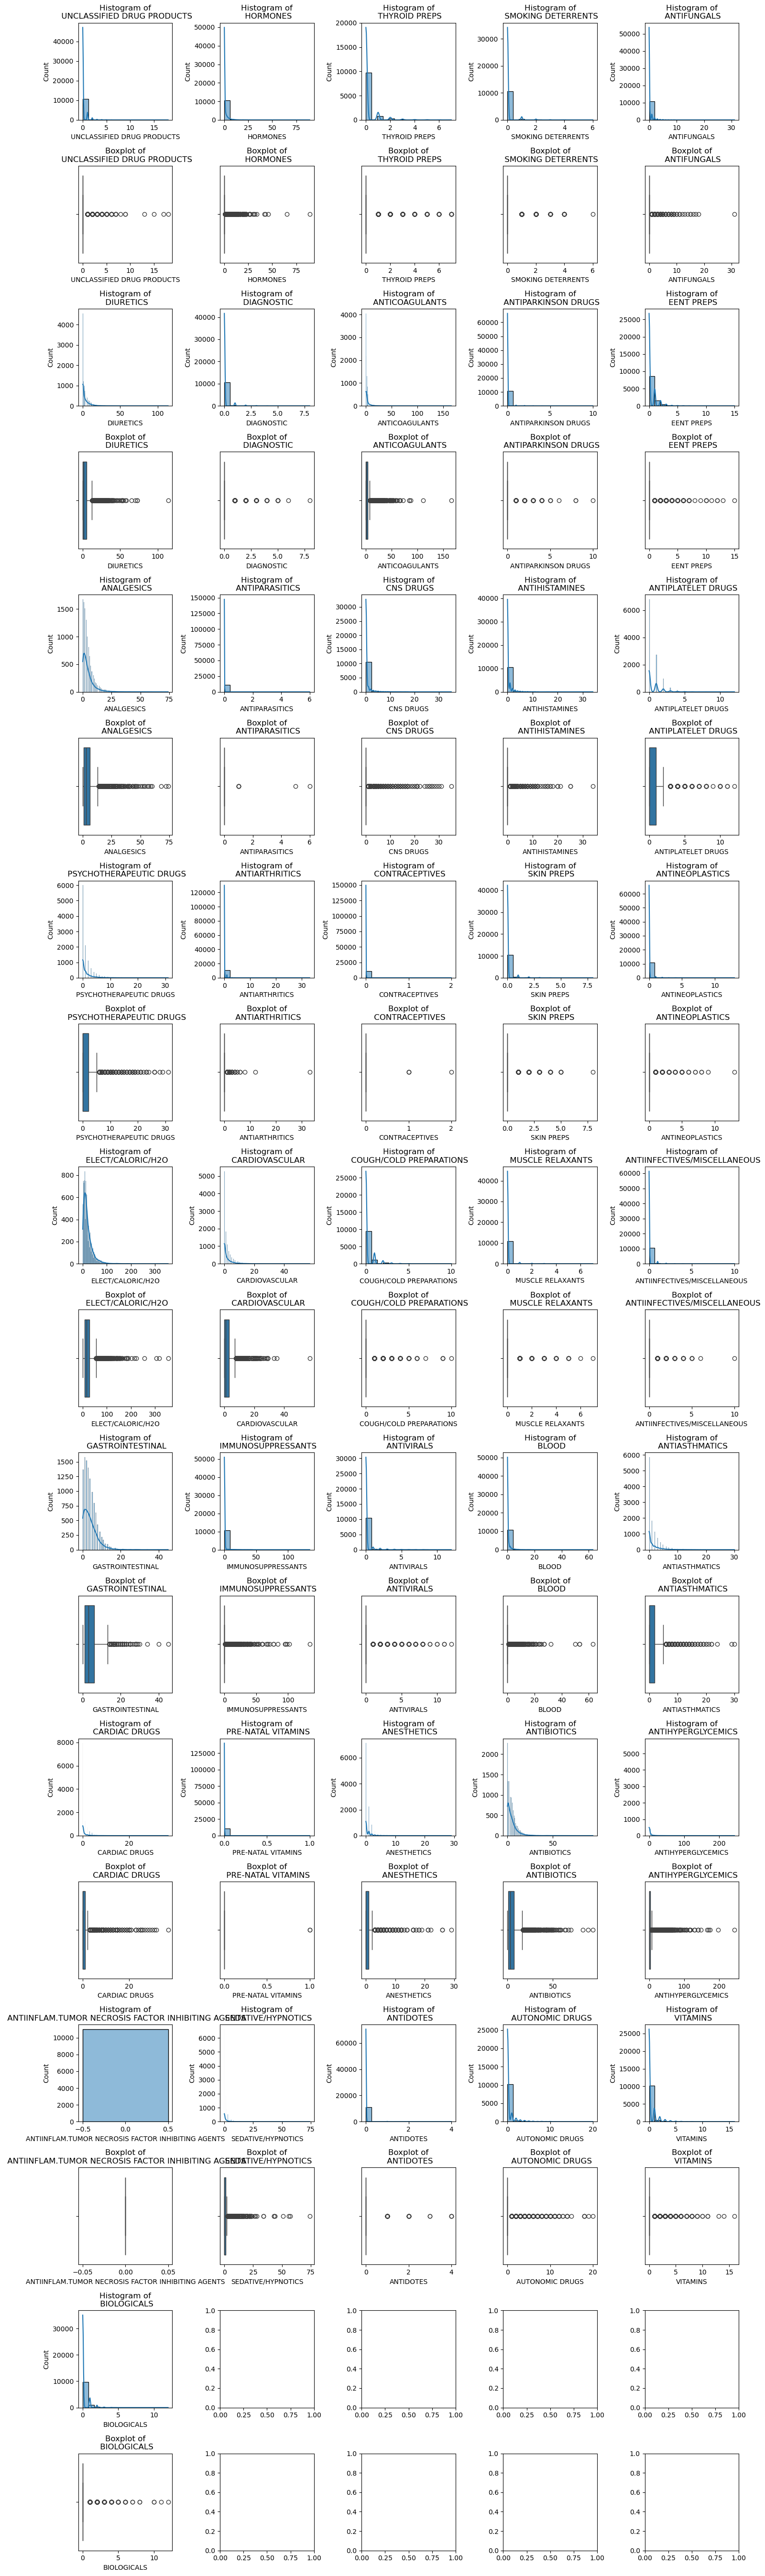

In [59]:
# plot distributions (train - median feature value)
cat_cols_median = [col for col in train_merged_df_median.columns[12:] if col in cat_cols or col in icd_cols]
num_cols_median = [col for col in train_merged_df_median.columns[12:] if col not in cat_cols_median]

# Plot categorical columns
print("Categorical features:")
num_rows = math.ceil(len(cat_cols_median) / 5)
fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))
axs = axs.flatten()
for i, col in enumerate(cat_cols_median):
    sns.countplot(x=col, data=train_merged_df_median, ax=axs[i])
    axs[i].set_title(f'Distribution of\n {col}')
plt.tight_layout()
plt.show()

# Plot numerical columns
print("Numerical features:")
num_rows = math.ceil(len(num_cols_median) / 5) * 2  
fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))
axs = axs.flatten()
for i, col in enumerate(num_cols_median):
    row = (i // 5) * 2  
    sns.histplot(train_merged_df_median[col], kde=True, ax=axs[row*5 + i%5])  
    sns.boxplot(x=train_merged_df_median[col], ax=axs[(row+1)*5 + i%5])  
    axs[row*5 + i%5].set_title(f'Histogram of\n {col}')
    axs[(row+1)*5 + i%5].set_title(f'Boxplot of\n {col}')
plt.tight_layout()
plt.show()

Categorical features:


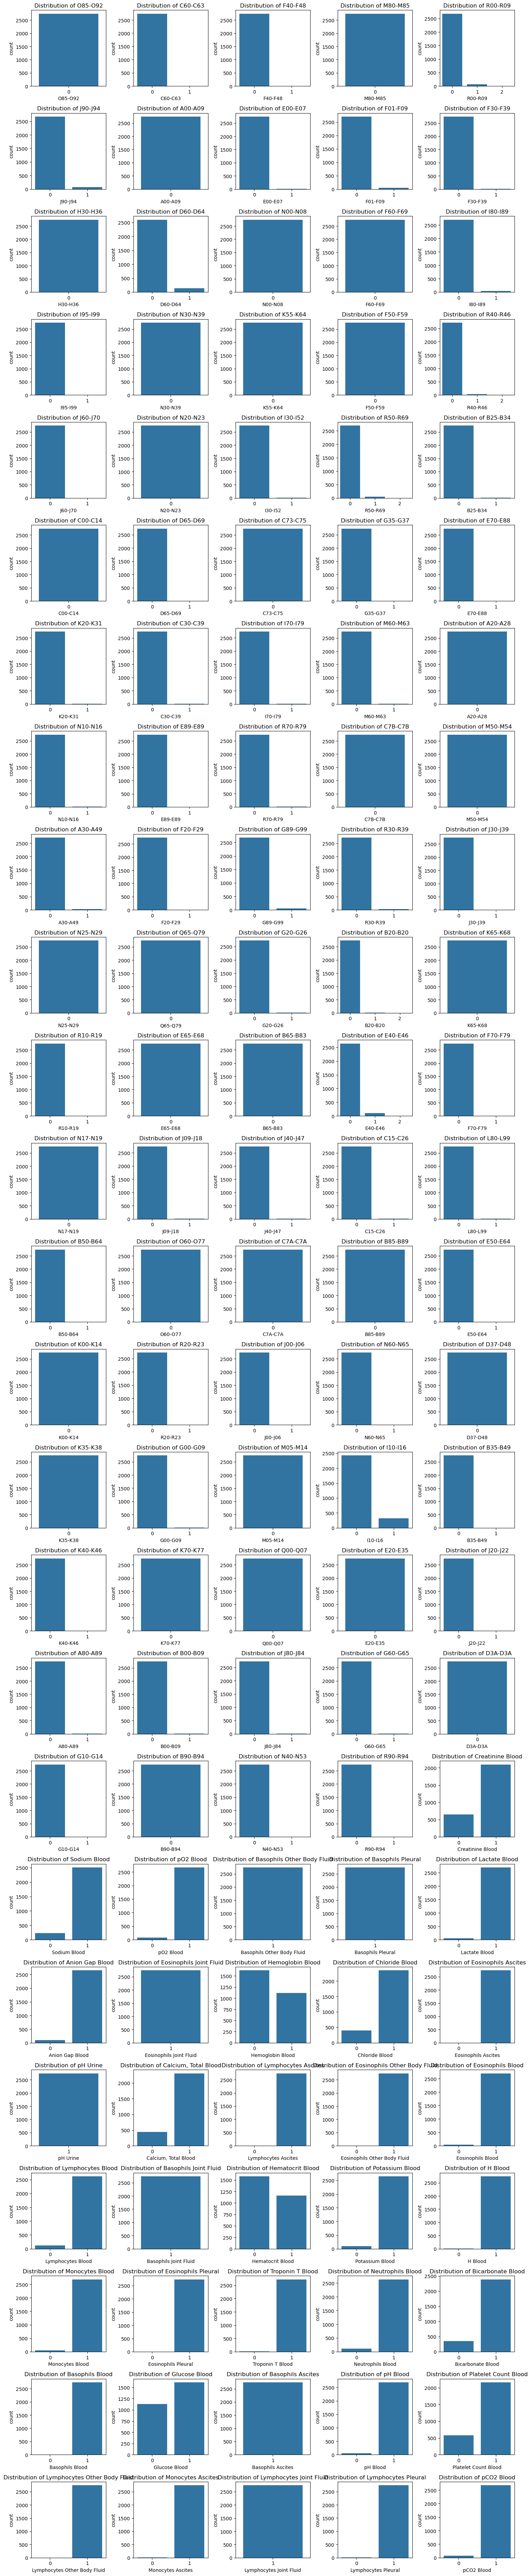

Numerical features:


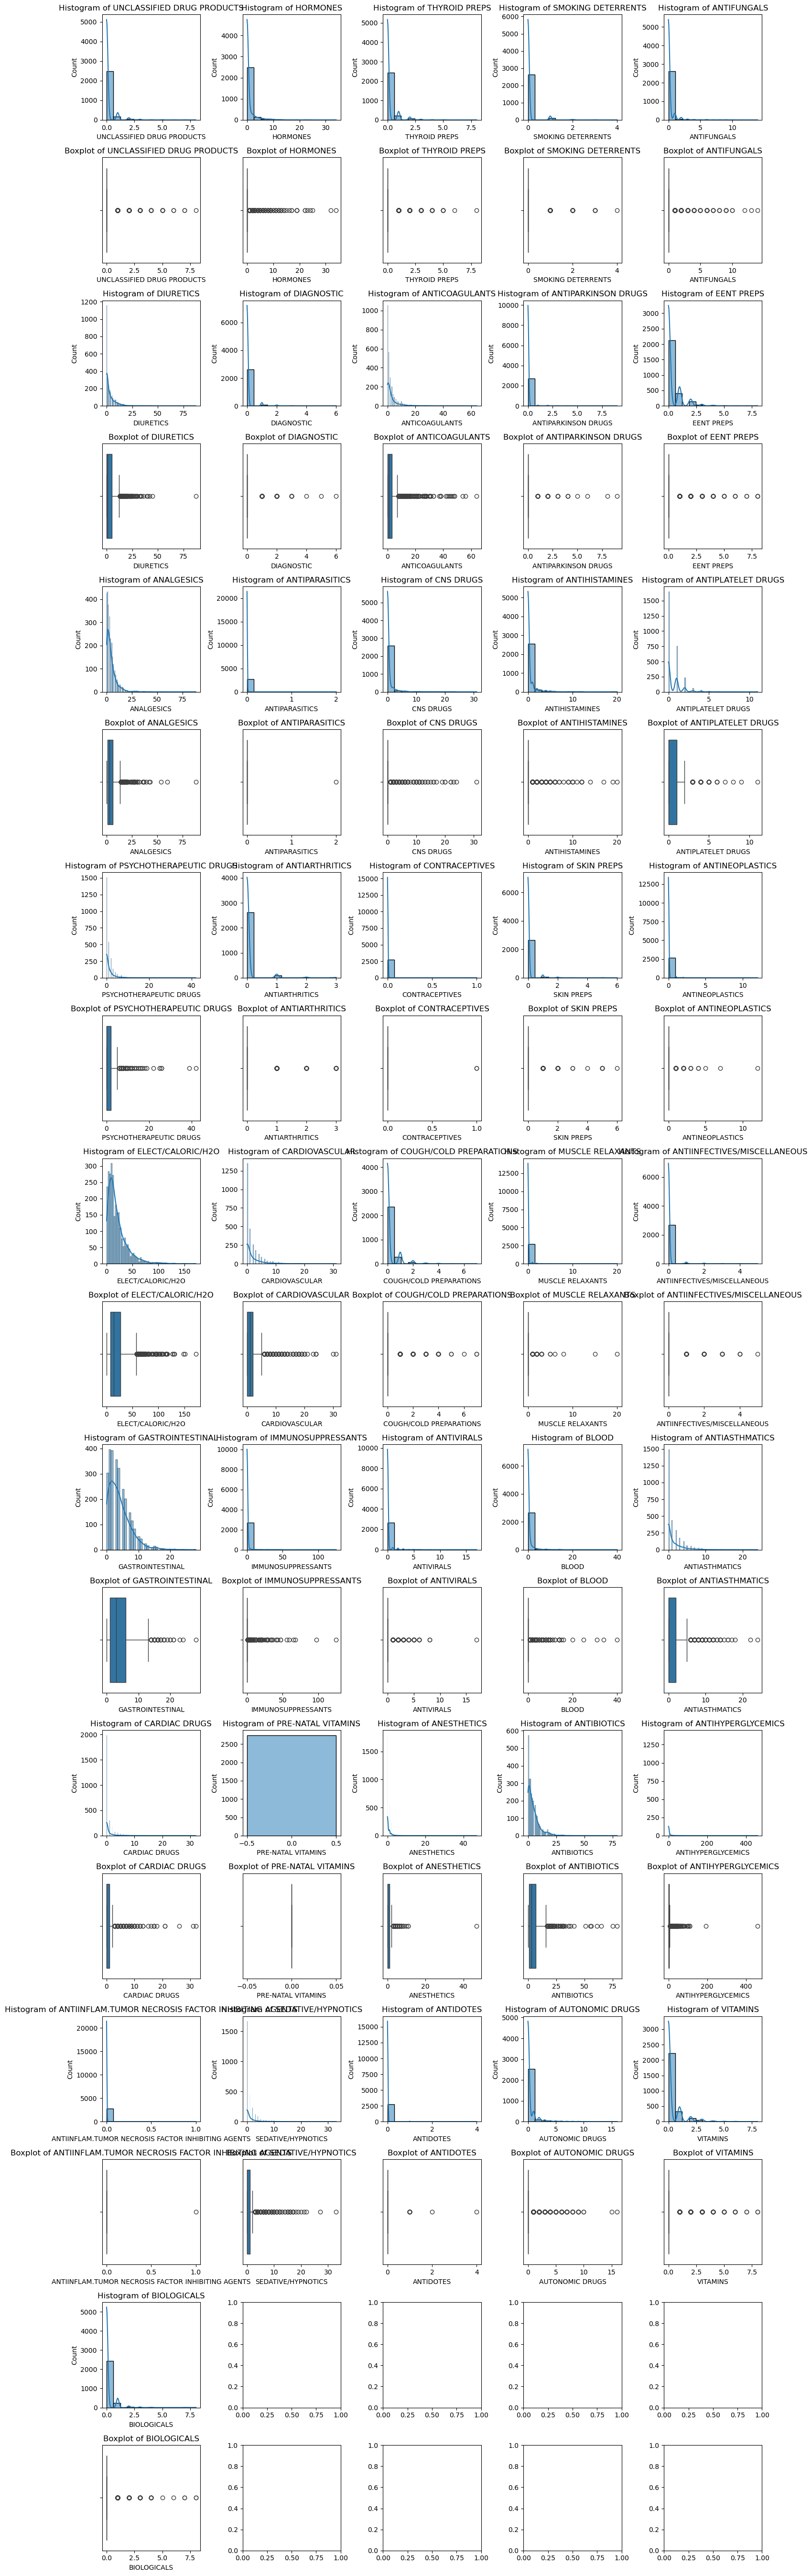

In [34]:
# Remove 'readmitted_within_30days' from categorical columns
cat_cols.remove('readmitted_within_30days')
cat_cols_latest = [col for col in test_merged_df_latest.columns[12:] if col in cat_cols or col in icd_cols] 
num_cols_latest = [col for col in test_merged_df_latest.columns[12:] if col not in cat_cols_latest]

# Plot categorical features
print("Categorical features:")
num_rows_cat = math.ceil(len(cat_cols_latest) / 5)
fig_cat, axs_cat = plt.subplots(num_rows_cat, 5, figsize=(15, num_rows_cat * 3))
axs_cat = axs_cat.flatten()

for i, col in enumerate(cat_cols_latest):
    sns.countplot(x=col, data=test_merged_df_latest, ax=axs_cat[i])
    axs_cat[i].set_title(f'Distribution of {col}')
    
plt.tight_layout()
plt.show()

# Plot numerical features
print("Numerical features:")
num_rows_num = math.ceil(len(num_cols_latest) / 5) * 2  
fig_num, axs_num = plt.subplots(num_rows_num, 5, figsize=(15, num_rows_num * 3))
axs_num = axs_num.flatten()

for i, col in enumerate(num_cols_latest):
    row = (i // 5) * 2  
    sns.histplot(test_merged_df_latest[col], kde=True, ax=axs_num[row * 5 + i % 5])  
    sns.boxplot(x=test_merged_df_latest[col], ax=axs_num[(row + 1) * 5 + i % 5])  
    axs_num[row * 5 + i % 5].set_title(f'Histogram of {col}')
    axs_num[(row + 1) * 5 + i % 5].set_title(f'Boxplot of {col}')
    
plt.tight_layout()
plt.show()

Categorical features:


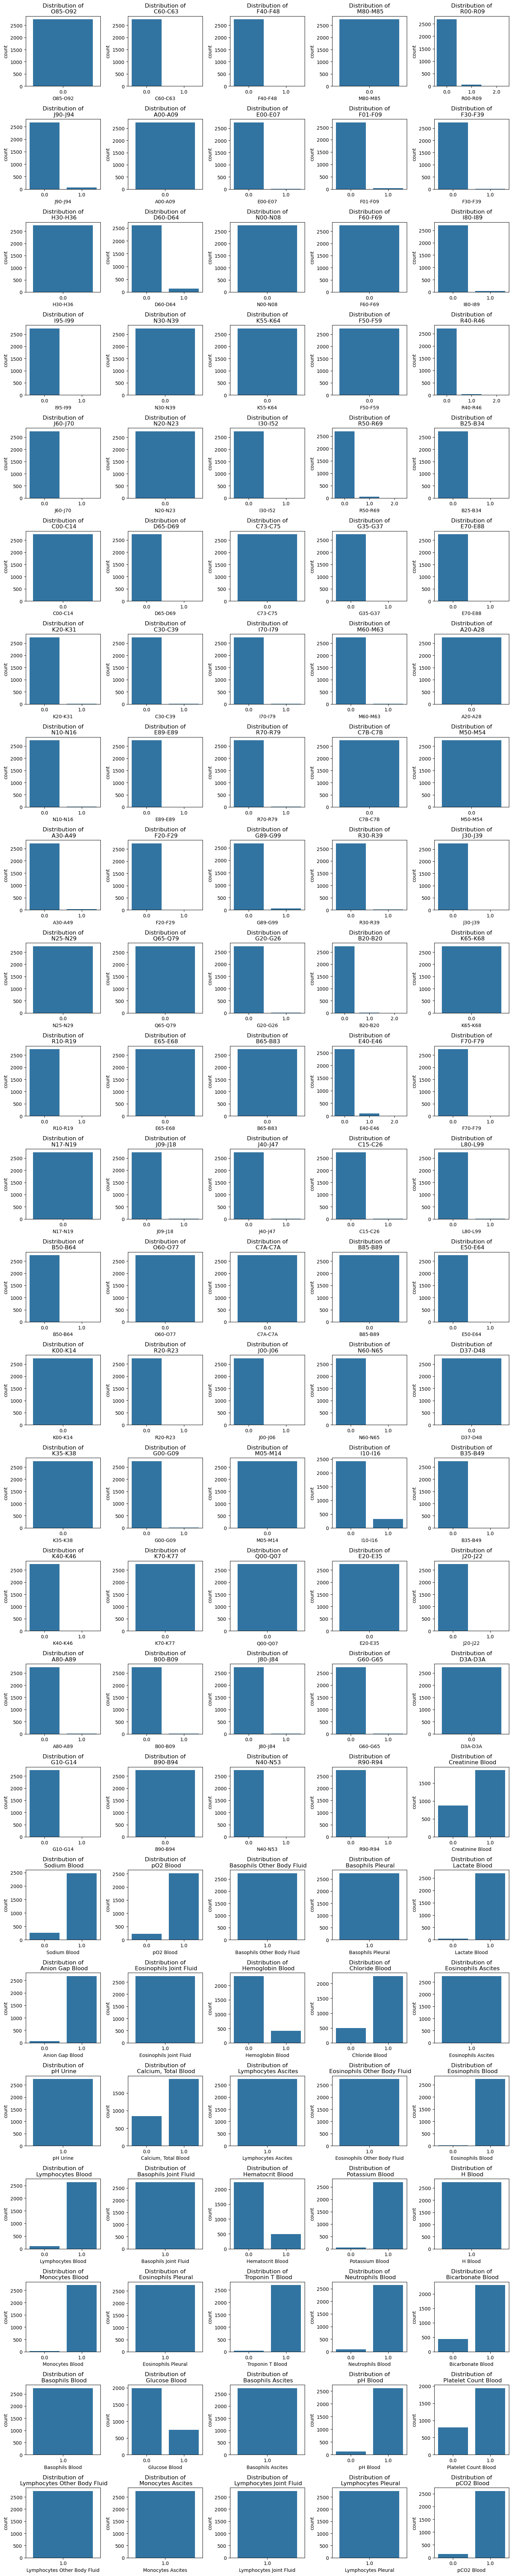

Numerical features:


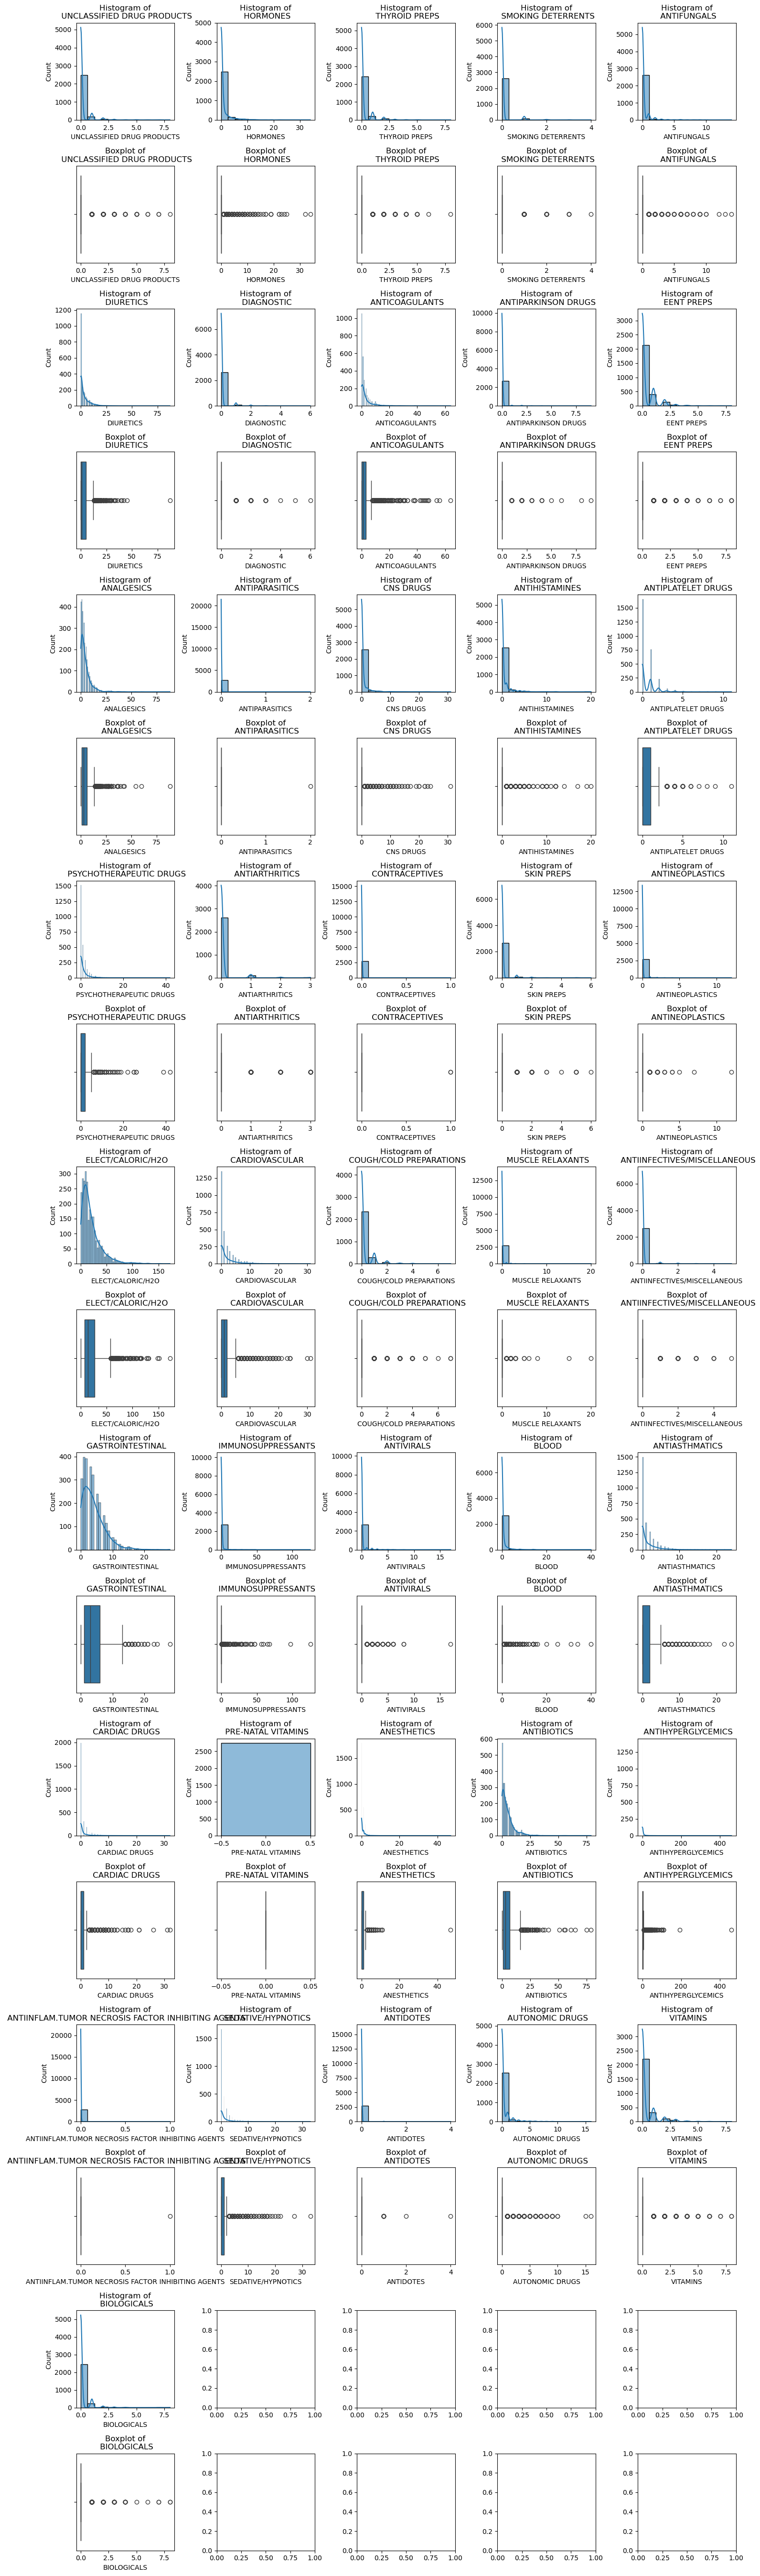

In [62]:
# plot distributions (test - median feature value)
cat_cols_median = [col for col in test_merged_df_median.columns[12:] if col in cat_cols or col in icd_cols]
num_cols_median = [col for col in test_merged_df_median.columns[12:] if col not in cat_cols_median]

# Plot categorical columns
print("Categorical features:")
num_rows = math.ceil(len(cat_cols_median) / 5)
fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))
axs = axs.flatten()
for i, col in enumerate(cat_cols_median):
    sns.countplot(x=col, data=test_merged_df_median, ax=axs[i])
    axs[i].set_title(f'Distribution of\n {col}')
plt.tight_layout()
plt.show()

# Plot numerical columns
print("Numerical features:")
num_rows = math.ceil(len(num_cols_median) / 5) * 2  
fig, axs = plt.subplots(num_rows, 5, figsize=(15, num_rows*3))
axs = axs.flatten()
for i, col in enumerate(num_cols_median):
    row = (i // 5) * 2  
    sns.histplot(test_merged_df_median[col], kde=True, ax=axs[row*5 + i%5])  
    sns.boxplot(x=test_merged_df_median[col], ax=axs[(row+1)*5 + i%5])  
    axs[row*5 + i%5].set_title(f'Histogram of\n {col}')
    axs[(row+1)*5 + i%5].set_title(f'Boxplot of\n {col}')
plt.tight_layout()
plt.show()

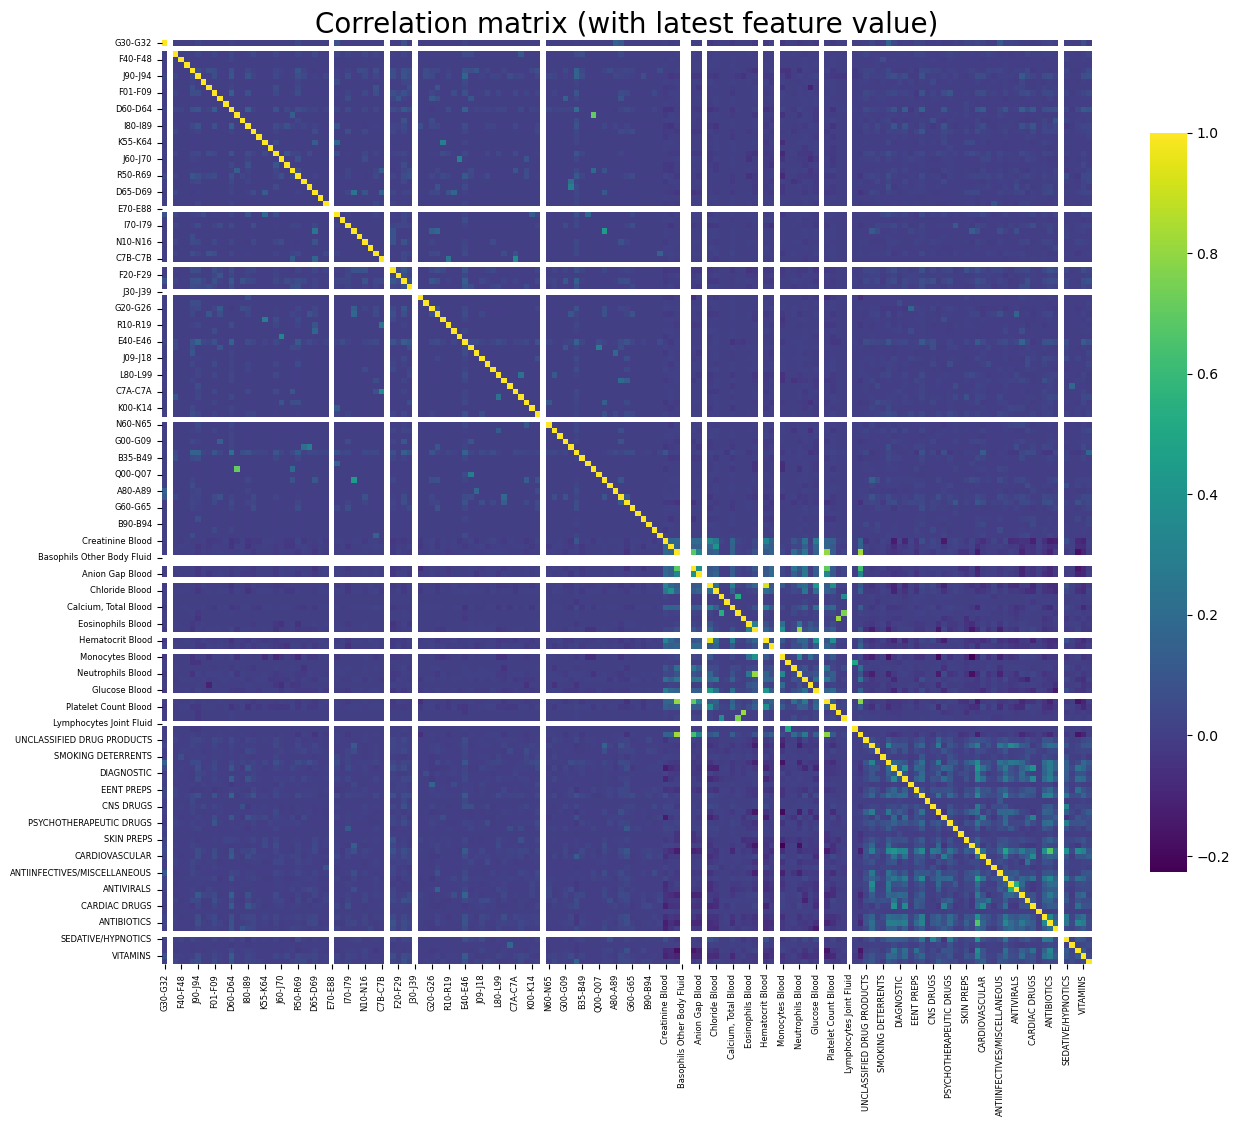

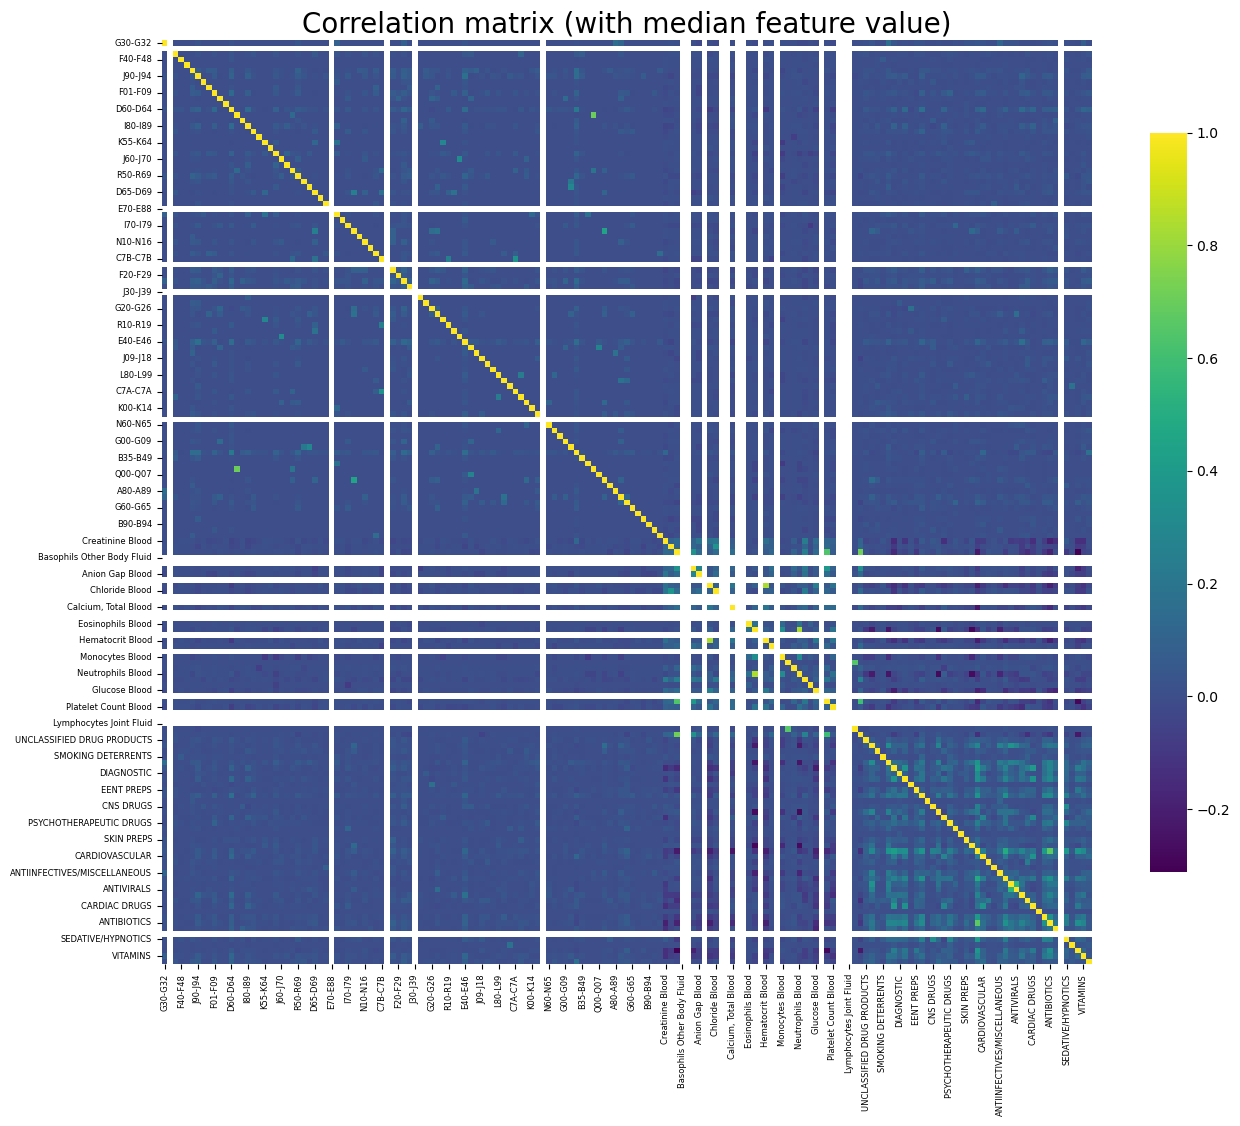

In [36]:
import seaborn as sns

# Correlation test for latest feature values
feat_resp_cols_latest = train_merged_df_latest.columns[12:].to_list()
corr_mat_latest = train_merged_df_latest[feat_resp_cols_latest].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_mat_latest, annot=False, fmt=".2f", cmap='viridis', cbar_kws={"shrink": .8})
plt.title("Correlation matrix (with latest feature value)", fontsize=20)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

# Correlation test for median feature values
feat_resp_cols_median = train_merged_df_median.columns[12:].to_list()
corr_mat_median = train_merged_df_median[feat_resp_cols_median].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_mat_median, annot=False, fmt=".2f", cmap='viridis', cbar_kws={"shrink": .8})
plt.title("Correlation matrix (with median feature value)", fontsize=20)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

In [40]:
# drop features with constant values in the training set
feat_cols_latest = train_merged_df_latest.columns[13:].to_list()
feat_cols_median = train_merged_df_median.columns[13:].to_list()
const_cols_latest = [col for col in feat_cols_latest if train_merged_df_latest[col].nunique() <= 1]
const_cols_median = [col for col in feat_cols_median if train_merged_df_median[col].nunique() <= 1]
print(const_cols_latest)
print(const_cols_median)

train_merged_df_latest = train_merged_df_latest.drop(columns=const_cols_latest, axis=1)
train_merged_df_median = train_merged_df_median.drop(columns=const_cols_median, axis=1)
test_merged_df_latest = test_merged_df_latest.drop(columns=const_cols_latest, axis=1)
test_merged_df_median = test_merged_df_median.drop(columns=const_cols_median, axis=1)

print(train_merged_df_latest.shape)
print(train_merged_df_median.shape)

['O85-O92', 'E70-E88', 'M50-M54', 'J30-J39', 'J00-J06', 'Basophils Other Body Fluid', 'Basophils Pleural', 'Eosinophils Joint Fluid', 'Basophils Joint Fluid', 'H Blood', 'Basophils Ascites', 'Lymphocytes Joint Fluid', 'ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS']
['O85-O92', 'E70-E88', 'M50-M54', 'J30-J39', 'J00-J06', 'Basophils Other Body Fluid', 'Basophils Pleural', 'Eosinophils Joint Fluid', 'Eosinophils Ascites', 'pH Urine', 'Lymphocytes Ascites', 'Eosinophils Other Body Fluid', 'Basophils Joint Fluid', 'H Blood', 'Basophils Ascites', 'Lymphocytes Other Body Fluid', 'Monocytes Ascites', 'Lymphocytes Joint Fluid', 'ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS']
(11022, 166)
(11022, 160)


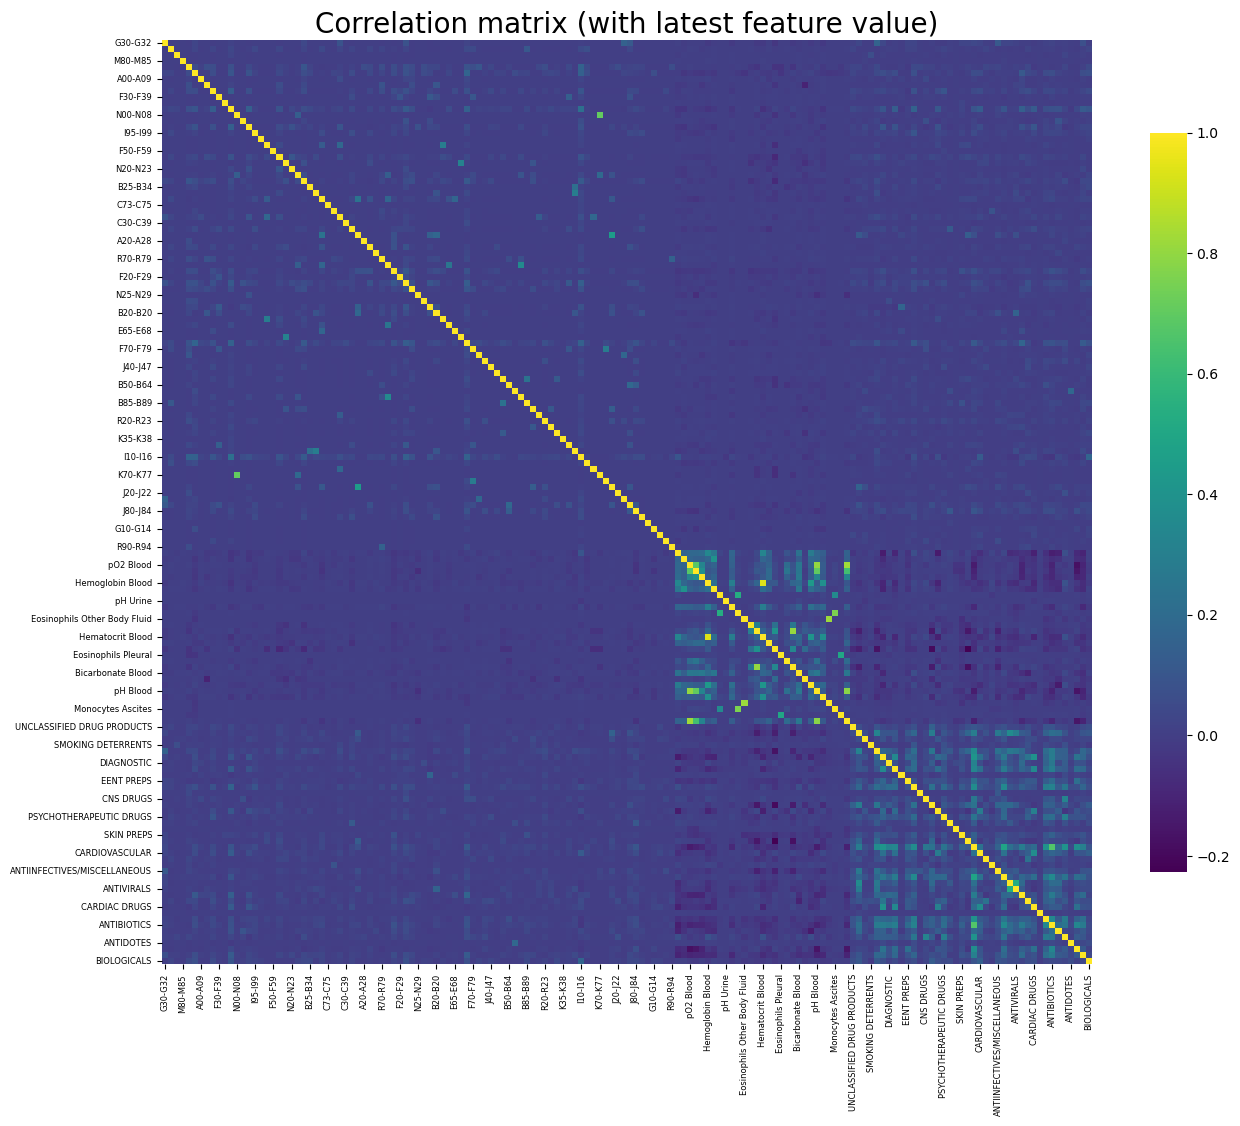

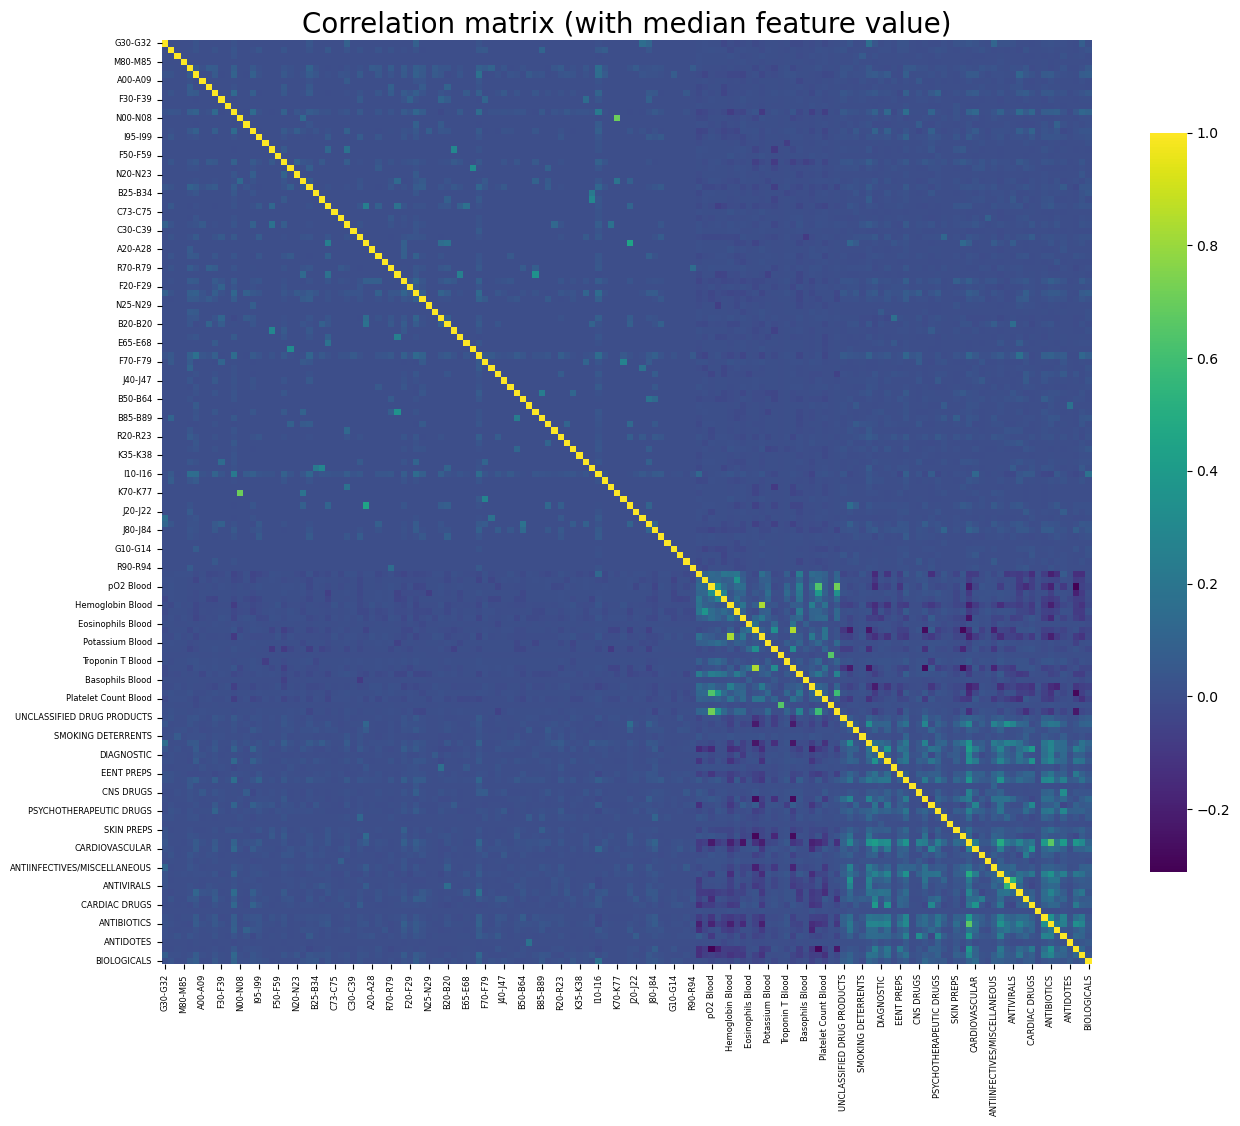

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation test after dropping constant features
# Latest feature values
feat_resp_cols_latest = train_merged_df_latest.columns[12:].to_list()
# Dropping constant features
train_merged_df_latest_dropped = train_merged_df_latest.loc[:, train_merged_df_latest.nunique() > 1]
corr_mat_latest = train_merged_df_latest_dropped[feat_resp_cols_latest].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_mat_latest, annot=False, fmt=".2f", cmap='viridis', cbar_kws={"shrink": .8})
plt.title("Correlation matrix (with latest feature value)", fontsize=20)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

# Median feature values
feat_resp_cols_median = train_merged_df_median.columns[12:].to_list()
# Dropping constant features
train_merged_df_median_dropped = train_merged_df_median.loc[:, train_merged_df_median.nunique() > 1]
corr_mat_median = train_merged_df_median_dropped[feat_resp_cols_median].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(corr_mat_median, annot=False, fmt=".2f", cmap='viridis', cbar_kws={"shrink": .8})
plt.title("Correlation matrix (with median feature value)", fontsize=20)
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()